In [1]:
import csv
import copy
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../assets/data2.csv', header=0, names = ["x1","x2","y"])
data.head()

,x1,x2,y
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [3]:
def plotData(data, label_x, label_y, label_pos, label_neg, axes=None):
    # Get indexes for class 0 and class 1
    neg = data['y'] == 0
    pos = data['y'] == 1
    
    # If no specific axes object has been passed, get the current axes.
    if axes == None:
        axes = plt.gca()
        
    axes.scatter(data[pos]['x1'], data[pos]['x2'], marker='+', c='orange', s=60, linewidth=2, label=label_pos)
    axes.scatter(data[neg]['x1'], data[neg]['x2'], c='blue', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True);

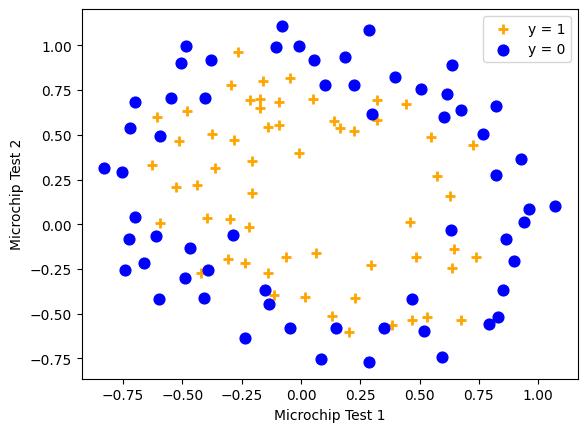

In [4]:
plotData(data, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')

In [5]:
n = data.shape[1]-1
x = data[data.columns[0:n]]

y = data[data.columns[n:n+1]]

# convert to np.array
X = x.values
y = y.values

In [6]:
def mapFeature( x1col, x2col):
    degrees = 10
    out = np.ones( (x1col.shape[0], 1) )
    # print(out[0:6])

    for i in range(1, degrees+1):
      for j in range(0, i+1):
        term1 = x1col ** (i-j)
        term2 = x2col ** (j)
        term  = (term1 * term2).reshape( term1.shape[0], 1 ) 
        out   = np.hstack(( out, term ))
        # print(out[0:6])
    return out

In [7]:
XX = mapFeature(X[:,0],X[:,1])
print(X.shape, XX.shape)

(118, 2) (118, 66)


In [8]:
from scipy.special import expit #Vectorized sigmoid function

# Hypothesis function and cost function for logistic regression
def hypothesis(mytheta, myX):
    return expit(np.dot(myX, mytheta))

In [9]:

def computeCost(mytheta, myX, myy, lambdaa = 0): 
    n = myy.size

    term1 = np.dot(-np.array(myy).T, np.log(hypothesis(mytheta, myX)))
    term2 = np.dot((1-np.array(myy)).T, np.log(1 - hypothesis(mytheta, myX)))
    regterm = (lambdaa/2) * np.sum(np.dot(mytheta[1:].T, mytheta[1:]))
    
    return float((1/n) * (np.sum(term1 - term2) + regterm))

In [10]:
def sigmoid(z):
    # protects overflow
    z = np.clip(z, -500, 500)
    g = 1 / (1 + np.exp(-z))
    
    return g

def compute_gradient_logistic(X, y, w):
    m, n = X.shape
    dj_dw = np.zeros((n))

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i], w))
        err_i = f_wb_i - y[i]
        
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]
        
    return dj_dw/m

In [12]:
initial_theta = np.zeros(XX.shape[1])
print(initial_theta.shape)

# def optimizeRegularizedTheta(mytheta,myX,myy,mylambda=0.):
#     result = optimize.minimize(computeCost, mytheta, args=(myX, myy, mylambda),  method='BFGS', options={"maxiter":500, "disp":False} )
#     return np.array([result.x]), result.fun

def optimizeRegularizedTheta(mytheta, myX, myy, alpha, num_iters, lambdaa=0):
    J_history = []
    m = myX.shape[0]
    w = copy.deepcopy(mytheta)

    for i in range(num_iters):
        dj_dw = compute_gradient_logistic(myX, myy, w)   

        w = w * (1- alpha * (lambdaa/m)) - alpha * dj_dw              
      
        if i<100000:
            J_history.append(computeCost(w, myX, myy, lambdaa))

        if i % math.ceil(num_iters / 10) == 0:
            print(f"Iteration at {i:4d}: Cost {J_history[-1]}")
          
    return w, min(J_history)
    
theta, mincost = optimizeRegularizedTheta(initial_theta, XX, y, 0.1, 100)
print(theta.shape)
print(mincost)

(66,)
Iteration at    0: Cost 0.691100342525338
Iteration at   10: Cost 0.6745247304834239
Iteration at   20: Cost 0.662429140756798
Iteration at   30: Cost 0.6527223265301215
Iteration at   40: Cost 0.6444403143538936
Iteration at   50: Cost 0.6371093503528475
Iteration at   60: Cost 0.6304730545334474
Iteration at   70: Cost 0.6243774784919751
Iteration at   80: Cost 0.6187210453052703
Iteration at   90: Cost 0.6134315346366916
(66,)
0.6089396397803091


In [13]:
def plotBoundary(mytheta, myX, myy, mylambda=0.):
    """
    Function to plot the decision boundary for arbitrary theta, X, y, lambda value
    Inside of this function is feature mapping, and the minimization routine.
    It works by making a grid of x1 ("xvals") and x2 ("yvals") points,
    And for each, computing whether the hypothesis classifies that point as
    True or False. Then, a contour is drawn with a built-in pyplot function.
    """
    alpha = 0.1
    iters = 1000

    theta, mincost = optimizeRegularizedTheta(mytheta, myX, myy, alpha, iters, mylambda)
    print(theta, '\n\nCost: ', mincost, '\n \n')

    xvals = np.linspace(-1, 1.5, 50)
    yvals = np.linspace(-1, 1.5, 50)
    zvals = np.zeros((len(xvals), len(yvals)))

    for i in range(len(xvals)):
        for j in range(len(yvals)):
            myfeaturesij = mapFeature(np.array([xvals[i]]), np.array([yvals[j]]))
            zvals[i][j] = np.dot(theta, myfeaturesij.T)
            
    zvals = zvals.transpose()
    u, v = np.meshgrid(xvals, yvals)
    mycontour = plt.contour(xvals, yvals, zvals, [0])

    fmt = {0:'Lambda = %d'%mylambda}
    plt.clabel(mycontour, inline=1, fontsize=15, fmt=fmt)
    plt.title("Decision Boundary")

Iteration at    0: Cost 0.691100342525338
Iteration at  100: Cost 0.6084547570625648
Iteration at  200: Cost 0.5695610710258278
Iteration at  300: Cost 0.5416710089367658
Iteration at  400: Cost 0.5198661671992133
Iteration at  500: Cost 0.5021505299816057
Iteration at  600: Cost 0.4873998933845834
Iteration at  700: Cost 0.47488942767650455
Iteration at  800: Cost 0.4641208383686551
Iteration at  900: Cost 0.4547377973709433
[ 1.26417001e+00  7.35785885e-01  1.34575328e+00 -2.05425981e+00
 -9.41669252e-01 -1.20175477e+00  2.36484563e-01 -4.14345656e-01
 -4.16023101e-01 -1.18983482e-02 -1.50604511e+00 -8.73088139e-02
 -6.65501535e-01 -2.97257007e-01 -1.06321371e+00 -1.61310274e-01
 -2.42833027e-01 -7.79800864e-02 -2.93290541e-01 -3.33313239e-01
 -3.29543875e-01 -1.06496165e+00  5.95148218e-03 -3.24248588e-01
 -5.39771789e-03 -3.48586876e-01 -1.63715987e-01 -8.23557181e-01
 -3.06198193e-01 -1.24851523e-01 -5.83636352e-02 -1.27239389e-01
 -5.16787175e-02 -1.85022617e-01 -2.23006646e-01 -

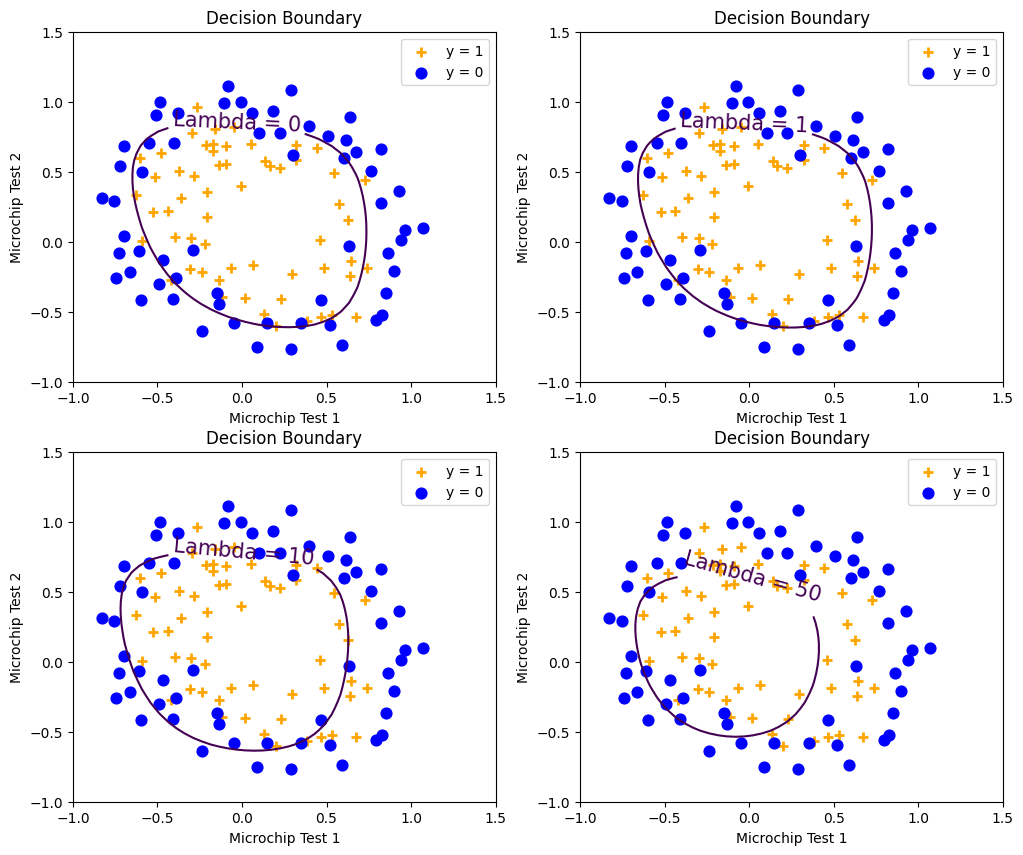

In [14]:
plt.figure(figsize=(12, 10))

plt.subplot(221)
plotData(data, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')
plotBoundary(initial_theta, XX, y, 0)

plt.subplot(222)
plotData(data, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')
plotBoundary(initial_theta, XX, y, 1)

plt.subplot(223)
plotData(data, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')
plotBoundary(initial_theta, XX, y, 10)

plt.subplot(224)
plotData(data, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')
plotBoundary(initial_theta, XX, y, 50)